## Denoising Diffusion Probabilistic Models

This notebook is a minimalistic implementation of the [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) paper.  The paper has been used to great effect for generating realistic images while also avoiding the mode collapse problems often seen in GANs.  To keep things simple we will be using the MNIST dataset. The method involves training a CNN to predict the noise component in a partially corrupted image.  At inference time we apply this CNN to pure white noise, the predicted noise component is subtracted from the input, renoised, and the result is feed into the network again.  We repeat this for a large number of steps (1000 in this notebook) to generate a new image modelled after the training data. The CNN architecure is somewhat arbitrary, but following the paper we will use a modified version of U-Net.


## Setup

Firstly, let's import our libraries and define some helper functions.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import diffusers
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
from scipy import linalg

In [2]:
# Set random seed for reproducability
def set_seed():
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

In [3]:
# Are we on GPU or CPU?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

Now, let download our dataset. For this notebook we will use the MNIST dataset of handwriten digits.

In [4]:
# Define batch size
bs = 64

# Define transforms for the images
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download the training data
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

# Download the test dataset
dataset_val = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
dataloader_val = DataLoader(dataset, batch_size=bs, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


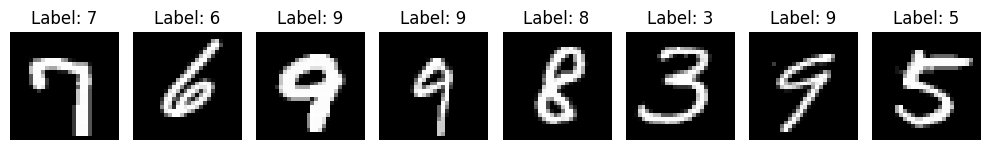

In [5]:
# Get a batch of images
images, labels = next(iter(dataloader))

# Create a 2x2 subplot
fig, axes = plt.subplots(1, 8, figsize=(10, 6))

# Display 4 images
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {labels[i].item()}')

plt.tight_layout()
plt.show()

## Model

The neural network architectures we will use is a UNet with three downsampling blocks and three upsampling blocks. We will creates this network using the diffusers library and you can change its archicture via the config variable. For example, you change the depth of the network using the layers_per_block option, which controls the number of layer for each of the up/down blocks.

This exact architecture is also commonly used for diffusion models.  Here is an example of UNet architecture, this diagram differs from our architecture in some ways, but the general structure is the same.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="540">

In [6]:
# Initialize model and do some training
def create_unet():
    model = diffusers.UNet2DModel(
        sample_size=28,          # input image size
        in_channels=1,           # grayscale input
        out_channels=1,          # grayscale output
        block_out_channels=(64, 64, 128),
        down_block_types=("DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
        up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
        num_class_embeds=11,
    ).to(device)
    return model

## Noise Schedule

How do we add noise to these MNIST images?  Over $T=1000$ time steps $t$, we gradually add Gaussian noise. We call this the forward process and model it using $q(x_t|x_{t-1})$ where $x_t$ is an image at time step $t$.  So at time $x_0$ we have an MNIST image uncorrupted by noise, at $x_{483}$ we have an MNIST image that is mixed with noise, and at $x_{1000}$ we have pure noise.

To add this noise we will use a linear schedule controlled by parameter $\beta=0.0001...0.02$

$$ q(x_t|x_{t-1})=\mathcal{N}(\sqrt{1-\beta_t}x_{t-1}, \beta_t\boldsymbol{I})$$

However, we have a problem.  To calculate $x_{1000}$ would would need to apply this formular recursivly 1000 times!  So to simplify this we can rewrite it as

$$ q(x_t|x_0)=\mathcal{N}(\sqrt{\bar{\alpha_t}}x_0, (1-\bar{\alpha_t})\boldsymbol{I})$$

where
$$\alpha_t=1-\beta_t$$
$$\bar{\alpha_t}=\prod_{s=1}^t{\alpha_s}$$

These values are computed below and will be very important during both training sampling.

In [7]:
# Noise schedule
beta_start = 0.0001
beta_end = 0.02
timesteps = 1000
betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

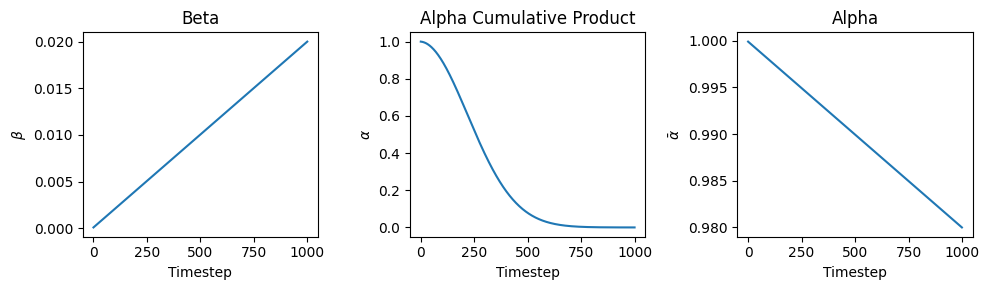

In [8]:
# Display noise schedule values
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

ax1.plot(betas.cpu().numpy())
ax1.set_xlabel("Timestep")
ax1.set_title("Beta")
ax1.set_ylabel(r'$\beta$')

ax2.plot(alphas_cumprod.cpu().numpy())
ax2.set_xlabel("Timestep")
ax2.set_title("Alpha Cumulative Product")
ax2.set_ylabel(r'$\alpha$')

ax3.plot(alphas.cpu().numpy())
ax3.set_xlabel("Timestep")
ax3.set_title("Alpha")
ax3.set_ylabel(r'$\bar{\alpha}$')

plt.tight_layout()

## Sampling

Here we define code to sample (or generate) a batch of images. We will use the [Denoising Diffusion Implicit Models (DDIM)](https://arxiv.org/abs/2010.02502) formula to generate our images as it allows to skip steps, thereby generating our image faster. This can be done using the following algorithm.

___
### **Algorithm 2** Sampling
___
1. &nbsp;$x_T \sim \mathcal{N}(0, I)$
2. &nbsp;$\textbf{for } t=T,...,1 \textbf{ do}$
3. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\epsilon \sim \mathcal{N}(0, I) \text{ if } t>1, \text{ else } \epsilon=0$
4. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ${x}_{t-1}=\sqrt{\alpha_{t-1}} \left( \frac{{x}_t-\sqrt{1-\alpha_t}D_{\theta}(x_t,t)}{\sqrt{\alpha_t}} \right) + \sqrt{1-\alpha_{t-1}-\sigma_t} D_{\theta}(x_t,t) + \sigma_t\epsilon$
5. &nbsp;$\textbf{end for}$
6. &nbsp;$\textbf{return } x_0$
___

In [9]:
# Sampling
@torch.no_grad()
def sample(x, net, labels=None, total_steps=50, w=1.0):

    # Generate random labels if non are provided
    if labels is None:
        labels = torch.randint(10, (x.shape[0],)).to(device)

    # Choose a non-Markovian (DDIM-style) schedule of indices to visit
    schedule = torch.linspace(0, timesteps - 1, total_steps, dtype=torch.long).to(device)

    # Inference : chain with total_steps steps (can skip)
    markov_chain = torch.zeros(total_steps + 1, x.shape[0], x.shape[1], x.shape[2], x.shape[3])
    markov_chain[0] = x
    for idx in reversed(range(total_steps)):

        # Get the correct shape for timesteps t (from the schedule)
        t_val = schedule[idx]
        t = torch.full((x.shape[0],), t_val.item(), dtype=torch.long).to(device)

        # Copy tensors for CFG
        if w > 1.0:
            x_input = torch.concat([x, x], dim=0)
            labels_input = torch.concat([labels, torch.ones_like(labels) * 10], dim=0)
            t_input = torch.concat([t, t], dim=0)
        else:
            x_input = x
            t_input = t
            labels_input = labels

        # Run neural network
        predicted_noise = net(x_input, t_input, labels_input).sample

        # Perform classifier free guidance (CFG)
        if w > 1.0:
            predicted_noise_cond, predicted_noise_uncond = predicted_noise[:x.shape[0]], predicted_noise[x.shape[0]:]
            predicted_noise = w * predicted_noise_cond + (1 - w) * predicted_noise_uncond

        # Equation 12 - Denoising Diffusion Implicit Models (https://arxiv.org/pdf/2010.02502)
        alpha_cumprod = alphas_cumprod[t][:, None, None, None]
        if idx == 0:
            alpha_cumprod_minus_1 = torch.tensor(1.0, device=device)
        else:
            t_prev = torch.full((x.shape[0],), schedule[idx - 1].item(), dtype=torch.long).to(device)
            alpha_cumprod_minus_1 = alphas_cumprod[t_prev][:, None, None, None]

        x = torch.sqrt(alpha_cumprod_minus_1) * ((x - torch.sqrt(1 - alpha_cumprod) * predicted_noise) / torch.sqrt(alpha_cumprod)) \
            + torch.sqrt(1 - alpha_cumprod_minus_1) * predicted_noise
        markov_chain[total_steps - idx] = x.cpu()

    return markov_chain



## Evaluation Metric

To evaluate our model we will use the Fréchet inception distance (FID) which is a proxy for image quality. To calculate this metric we will first need to train a classifier, for which we will use a modified ResNet.

In [10]:
class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()

        # Download ResNet18 model and replace last layer
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features=512, out_features=10),
        )
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.eval()

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        features = torch.flatten(x, 1)        # second-to-last features

        pred = self.resnet.fc(features)       # final logits
        return pred, features

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classifier = CustomResNet()
classifier = classifier.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


In [11]:
# Hyperparameters
epochs  = 4
total_classes = 10
learning_rate = 0.0001

# Training loop objects
loss_bce = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

# Define loss history objects
train_losses = []
validation_losses = []

# Main training loop
for e in range(epochs):

    # TRAINING
    epoch_train_losses = []
    for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Every data instance is an input + label pair
        images, labels = data
        one_hot_labels = F.one_hot(labels, total_classes)
        images, one_hot_labels = images.to(device), one_hot_labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        preds  = classifier(images.float())[0]

        # Compute the loss and its gradients
        loss = loss_bce(preds, one_hot_labels.float())
        epoch_train_losses.append(loss.item()) # Save results
        loss.backward()

        # Adjust learning weights
        optimizer.step()

    # Save and print loss
    train_losses.append(sum(epoch_train_losses) / len(epoch_train_losses))
    print("Epoch:", e, "- Training Loss:", train_losses[-1])

    # VALIDATION
    epoch_validation_losses = []
    validation_predicted_labels = np.array([])
    validation_ground_truth_labels = np.array([])
    for i, data in tqdm(enumerate(dataloader_val), total=len(dataloader_val)):
                # Every data instance is an input + label pair
        images, labels = data
        one_hot_labels = F.one_hot(labels, total_classes)
        images, one_hot_labels = images.to(device), one_hot_labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        preds  = classifier(images.float())[0]

        # Compute the loss and its gradients
        loss = loss_bce(preds, one_hot_labels.float())
        epoch_validation_losses.append(loss.item())

        # Save results
        validation_predicted_labels = np.concatenate((validation_predicted_labels, torch.argmax(preds, dim=1).cpu().detach()))
        validation_ground_truth_labels = np.concatenate((validation_ground_truth_labels, torch.argmax(one_hot_labels, dim=1).cpu().detach()))

    validation_losses.append(sum(epoch_validation_losses) / len(epoch_validation_losses))
    print("Epoch:", e, "- Validation Loss:", validation_losses[-1])
    print('Validation Set Accuracy:', ((len(validation_ground_truth_labels) - np.count_nonzero(validation_predicted_labels - validation_ground_truth_labels)) / len(validation_ground_truth_labels)) * 100, '%')


100%|██████████| 938/938 [00:25<00:00, 36.63it/s]


Epoch: 0 - Training Loss: 0.05444589123809472


100%|██████████| 938/938 [00:18<00:00, 49.60it/s]


Epoch: 0 - Validation Loss: 0.017857246738828735
Validation Set Accuracy: 97.13166666666667 %


100%|██████████| 938/938 [00:24<00:00, 37.80it/s]


Epoch: 1 - Training Loss: 0.01537603140600261


100%|██████████| 938/938 [00:23<00:00, 39.84it/s]


Epoch: 1 - Validation Loss: 0.013205093648488214
Validation Set Accuracy: 97.715 %


100%|██████████| 938/938 [00:32<00:00, 28.96it/s]


Epoch: 2 - Training Loss: 0.011921958979477348


100%|██████████| 938/938 [00:23<00:00, 39.27it/s]


Epoch: 2 - Validation Loss: 0.007879686648310817
Validation Set Accuracy: 98.75333333333333 %


100%|██████████| 938/938 [00:28<00:00, 32.71it/s]


Epoch: 3 - Training Loss: 0.009082971465724734


100%|██████████| 938/938 [00:22<00:00, 41.28it/s]

Epoch: 3 - Validation Loss: 0.006272637410829567
Validation Set Accuracy: 98.96166666666667 %


Text(0.5, 1.0, 'MNIST Classification Training Loss')

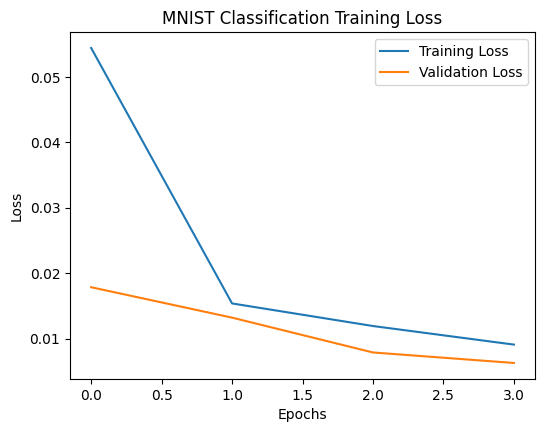

In [12]:
plt.figure(figsize=(6,4.5))
plt.plot(train_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MNIST Classification Training Loss')

Calculating the FID involve first passing our images through a classifier and retrieving features from the final hidden layer. This is done for both real images and fake images. We then fit a Gaussian distribution to both sets of features and calculate the Frechet distance between them using the following formula:

$$|\mu _{X}-\mu _{Y}|^{2}+\operatorname {tr} (\Sigma _{X}+\Sigma _{Y}-2(\Sigma _{X}\Sigma _{Y})^{1/2})$$

Where $\mu_X$ and $\mu_Y$ are the means of the Gaussians for the real and fake features, where as $\Sigma _{X}$ and $\Sigma _{Y}$ are the covarience matricies for these Gaussians. The lower the distance, the closer the two distributions, and the better the quality of our images.

In [13]:
def calculate_fid(diff_model):
    # set seed for repoducability
    set_seed()

    # Fake image stats
    fake_feats = torch.zeros(0,512)
    for _ in tqdm(range(50), desc="Generating Fakes"):
        # Generate samples
        noise = torch.randn(bs, 1, 28, 28).to(device).float()
        samples = sample(noise, diff_model).detach()
        _, features = classifier(samples[-1].float().to(device))
        features = features.double()
        if features.dim() == 1:
            features = features.unsqueeze(0)
        fake_feats = torch.concat([fake_feats, features.detach().cpu()])

    # Real image stats
    real_feats = torch.zeros(0,512)
    for real_imgs, _ in dataloader_val:
        _, features = classifier(real_imgs.float().to(device))
        features = features.double()
        if features.dim() == 1:
            features = features.unsqueeze(0)
        real_feats = torch.concat([real_feats, features.detach().cpu()])
        if real_feats.shape[0] >= fake_feats.shape[0]:
            break

    # Convert to numpy arrays for FID calculation
    real_feats_np = real_feats.numpy()
    fake_feats_np = fake_feats.numpy()

    # FID Calculation
    mu1 = np.mean(real_feats_np, axis=0)
    sigma1 = np.cov(real_feats_np, rowvar=False)
    mu2 = np.mean(fake_feats_np, axis=0)
    sigma2 = np.cov(fake_feats_np, rowvar=False)
    eps= 1e-6
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    if np.iscomplexobj(covmean):
        print("Complex part:", np.abs(covmean.imag).max())
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Training

The algorithm for training a diffusion model is shown below.  We also include code which contains addition step for logging and montoring the progress of the training.

___
### **Algorithm 1** Training
___
1. &nbsp;$\textbf{repeat}$
2. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_0 \sim q(x_0)$
3. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $t \sim \mathcal{U}(\{1,...,T\})$
4. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\epsilon \sim \mathcal{N}(0, I)$
5. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_t = \sqrt{\alpha_t} x_0 + \sqrt{1-\alpha_t} \epsilon$
6. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\text{Take gradient step on}$
7. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\nabla_\theta \|D_\theta(x_t, t) - \epsilon\|^2 $
___

In [14]:
def train_model(diffusion_model, ):

    # Set seed for reproducability
    set_seed()

    # Sample noise used for logging every epoch
    sampling_noise = torch.randn(5, 1, 28, 28).to(device).float()

    # Hyperparameters
    total_epochs = 4
    inject_start_epoch = 0

    # Optimizer
    optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-4)

    # Run training loop
    loss_history = {
        "mse" : [],
        "fid" : [],
    }
    for epoch in range(total_epochs):
        epoch_loss = 0
        for step, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            # Prepare data
            x = data[0].to(device)
            labels = data[1].to(device)

            # Change 15% of our labels to 10 (uncondition generation) for CFG
            labels[torch.rand_like(labels, dtype=torch.float) < 0.15] = 10

            # Timesteps
            t = torch.randint(0, timesteps, (x.shape[0],)).to(device)

            # Corrupt with noise
            noise = torch.randn_like(x).float()
            noisy_data = torch.sqrt(alphas_cumprod[t])[:, None, None, None] * x + \
                    torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None] * noise

            # Run neural network
            noise_preds = diffusion_model(noisy_data, t, labels).sample

            # Calculate and record loss
            loss = torch.nn.functional.mse_loss(noise_preds, noise)
            epoch_loss += loss.item()

            # Backwards pass
            optimizer.zero_grad()
            loss.backward(retain_graph=True)

            # Optimizer steps
            optimizer.step()

        # Logging
        loss_history["fid"].append(calculate_fid(diffusion_model))
        loss_history["mse"].append(epoch_loss / len(dataloader))
        print(f"Epoch [{epoch+1}/{total_epochs}] - Loss: {loss_history["mse"][-1] :.4f}, FID : {loss_history["fid"][-1]}")

        # Generate and plot samples
        samples = sample(sampling_noise, diffusion_model)
        fig, axes = plt.subplots(1,5, figsize=(10,2))
        for i, ax in enumerate(axes):
            ax.imshow(samples[-1,i,0].numpy(), cmap="gray")
            ax.axis("off")
        plt.show()

    return diffusion_model, loss_history

## Putting it all Together

Now we have defined everything we need we can train our diffusion model. While training the model we will calculate the FID and generate sample at every epoch to visualize how the training is going.

Generating Fakes: 100%|██████████| 50/50 [01:55<00:00,  2.31s/it]
/tmp/ipython-input-4087807800.py:39: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
/tmp/ipython-input-4087807800.py:39: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


Complex part: 1.3236247717720638e-05
Epoch [1/4] - Loss: 0.0524, FID : 1989.1751346145602


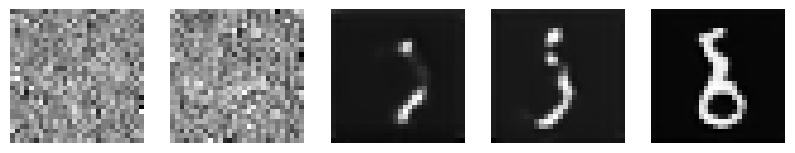

Generating Fakes: 100%|██████████| 50/50 [01:52<00:00,  2.24s/it]


Epoch [2/4] - Loss: 0.0283, FID : 822.7854501080888


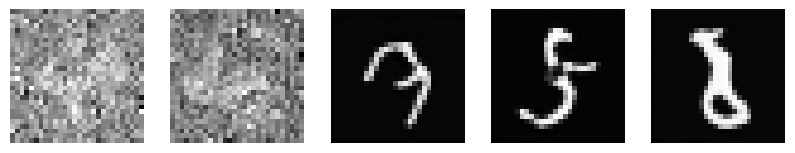

Generating Fakes: 100%|██████████| 50/50 [01:50<00:00,  2.22s/it]


Epoch [3/4] - Loss: 0.0253, FID : 375.0072280180177


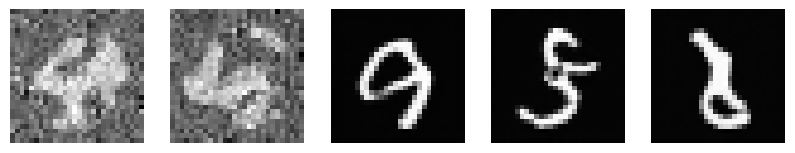

Generating Fakes: 100%|██████████| 50/50 [01:50<00:00,  2.22s/it]


Complex part: 5.497274233511536e-07
Epoch [4/4] - Loss: 0.0238, FID : 243.30320330163627


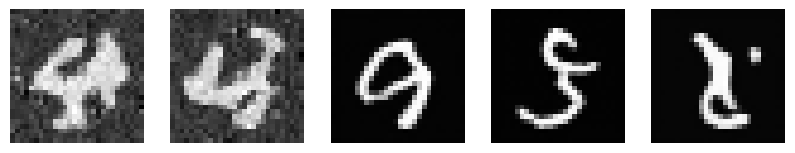

In [15]:
# Create the UNet model
model = create_unet()

# Train the diffusion mode
model, loss_histories = train_model(model)

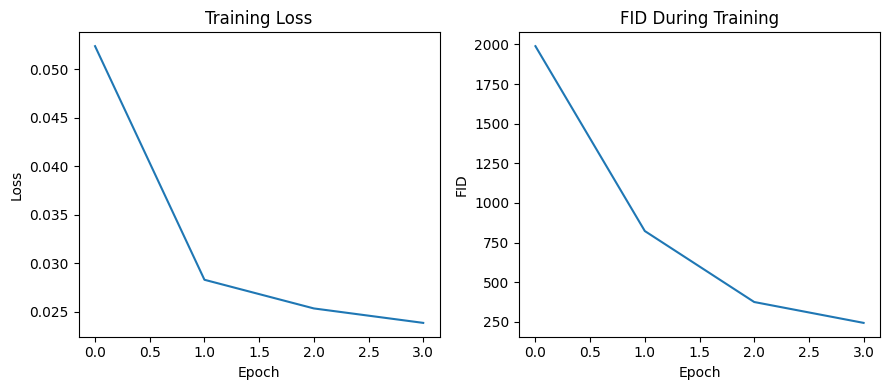

In [16]:
# Plot loss histories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

ax1.plot(loss_histories["mse"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")

ax2.plot(loss_histories["fid"])
ax2.set_xlabel("Epoch")
ax2.set_ylabel("FID")
ax2.set_title("FID During Training")

plt.tight_layout()

# Inference

Now let try to generate some image. Firstly, we will generate with the standard sampling procedure described in Algorithm 2.

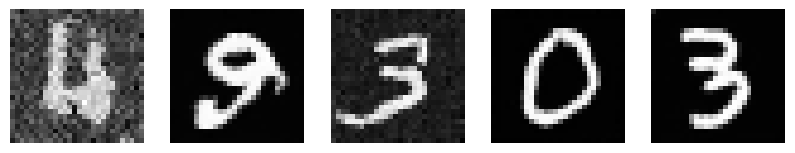

In [22]:
# Generate samples
noise = torch.randn(5, 1, 28, 28).to(device).float()
set_seed()
samples = sample(noise, model)

# Plot samples
fig, axes = plt.subplots(1,5, figsize=(10,2))
for i, ax in enumerate(axes):
    ax.imshow(samples[-1,i,0].numpy(), cmap="gray")
    ax.axis("off")
plt.show()


However, since we trained our model on both unconditional and conditional generation, we are able to use a technique called Classifier Free Guidance (CFG). When generating our samples this involve applying the following formula when predicting our noise:

$$\hat\epsilon = w D_{\theta}(x_t,t,y) + (1- w) D_{\theta}(x_t,t)$$

where $y$ is a condition (in our case that's a class label denoting the MNIST digit) and $w$ is a weight that control the strength of our classifier free guidance.  This has two effects. The first is to increase the likelihood of the class $y$ and the second is to increase image quality. The downside is that diversity is decreased, but in practice, this method is widely used due to its ability to noticably increase image quality.

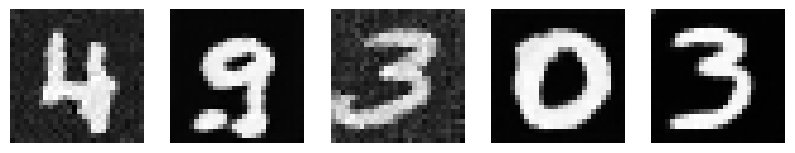

In [27]:
set_seed()
samples = sample(noise, model, w=5.0)

# Plot samples
fig, axes = plt.subplots(1,5, figsize=(10,2))
for i, ax in enumerate(axes):
    ax.imshow(samples[-1,i,0].numpy(), cmap="gray")
    ax.axis("off")
plt.show()